In [1]:
# Import Statements

%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib

#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

## 1 - Load Data

Before running the code, the data should be downloaded and foldered in the way that is usable for imagefolder function of the PyTorch. The following code assumes that the main directory for the dataset is 'data_dir' and it includes subdirectories for all of the separate classes.

For details on how to create those folders, pleaserefer to 'dataset/Folder_images.ipynb'

4
252
4
756


In [20]:
'''
Macros
'''
#uniform_sampler=False
batch_size=32
split=200
random_seed=1
shuffle=True
dataset = 'Hoarding'
CV = 4

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


'''Create ImageFolder objects for training and test'''

if dataset == 'Hoarding':
    data_dir = '/media/mtezcan/New Volume/Extreme Picture Finder/all images'
else:
    data_dir = '../images'  
    

if not CV == 0:  
    dset_train = datasets.ImageFolder(data_dir+'/train_val', data_transforms['train'])
    dset_val = datasets.ImageFolder(data_dir+'/train_val', data_transforms['val'])
    
    num_train = len(dset_train)
    indices = list(range(num_train))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
    splits = (num_train*np.linspace(0,1,CV+1)).astype(int)
    
    val_idx = [indices[splits[k]:splits[k+1]] for k in range(CV)]
    train_idx=[np.setdiff1d(indices,val_idx[k]) for k in range(CV)]
    '''Sampler functions for validation and training'''
    sampler_train = [torch.utils.data.sampler.SubsetRandomSampler(train_idx[k]) for k in range(CV)]
    sampler_val = [torch.utils.data.sampler.SubsetRandomSampler(val_idx[k]) for k in range(CV)]

    '''Define dataset loaders'''
    dset_loaders_arr = [{'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train[k],
                                                        num_workers=12),
                    'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val[k],
                                                        num_workers=12)} for k in range(CV)]
    dset_sizes={'train':int(len(dset_train)*(1-1/CV)),'val':int(len(dset_train)*(1/CV))}
else:
    dset_train = datasets.ImageFolder(data_dir+'/train', data_transforms['train'])
    dset_val = datasets.ImageFolder(data_dir+'/val', data_transforms['val'])

    '''Define dataset loaders'''
    dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train[k],
                                                        num_workers=12),
                    'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val[k],
                                                        num_workers=12)}

    
    dset_sizes={'train':len(dset_train),'val':len(dset_val)}

dset_classes = dset_train.classes
dset_classes_val = dset_val.classes
use_gpu = torch.cuda.is_available()

print(dset_sizes)
print('OR')
print('Number of training images '+str(len(val_idx)))
print('Number of validation images '+str(len(train_idx)))

print(dset_classes)
print(dset_classes_val)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

{'train': 924, 'val': 308}
OR
Number of training images 4
Number of validation images 4
['CIR 1', 'CIR 2', 'CIR 3', 'CIR 4', 'CIR 5', 'CIR 6', 'CIR 7', 'CIR 8', 'CIR 9']
['CIR 1', 'CIR 2', 'CIR 3', 'CIR 4', 'CIR 5', 'CIR 6', 'CIR 7', 'CIR 8', 'CIR 9']
GPU is available


In [11]:
dset_train.ConcatDataset(dset_val)
print(len(dset_train))

AttributeError: 'ImageFolder' object has no attribute 'ConcatDataset'

In [3]:
'''
Macros
'''
#uniform_sampler=False
batch_size=64
split=1000
random_seed=1
shuffle=True

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


'''Create ImageFolder objects for training and test'''
data_dir = '../images'
#data_dir = '/home/mtezcan/Documents/amazon/bin_images/0to5'
dset_train = datasets.ImageFolder(data_dir+'/train', data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir+'/val', data_transforms['val'])
'''dset_train = datasets.ImageFolder(data_dir+'/0to5', data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir+'/0to5', data_transforms['val'])'''


'''Validation split'''
num_train = len(dset_train)
indices = list(range(num_train))
val_idx=np.loadtxt('./dataset/validation.txt').astype(np.int)
train_idx=np.setdiff1d(indices,val_idx)

'''if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]'''

'''Sampler functions for validation and training'''
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}
'''dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val,
                                                    num_workers=12)}'''

dset_sizes={'train':len(dset_train),'val':len(dset_val)}
#dset_sizes={'train':len(dset_train)-1000,'val':1000}
dset_classes = dset_train.classes
dset_classes_val = dset_val.classes
use_gpu = torch.cuda.is_available()

print(dset_sizes)
print('OR')
print('Number of training images '+str(len(val_idx)))
print('Number of validation images '+str(len(train_idx)))

print(dset_classes)
print(dset_classes_val)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

{'train': 326472, 'val': 35495}
OR
Number of training images 1000
Number of validation images 325571
['0', '1', '2', '3', '4', '5']
['0', '1', '2', '3', '4', '5']
GPU is available


In [ ]:
print(np.max(val_idx))

Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 906, 1810])


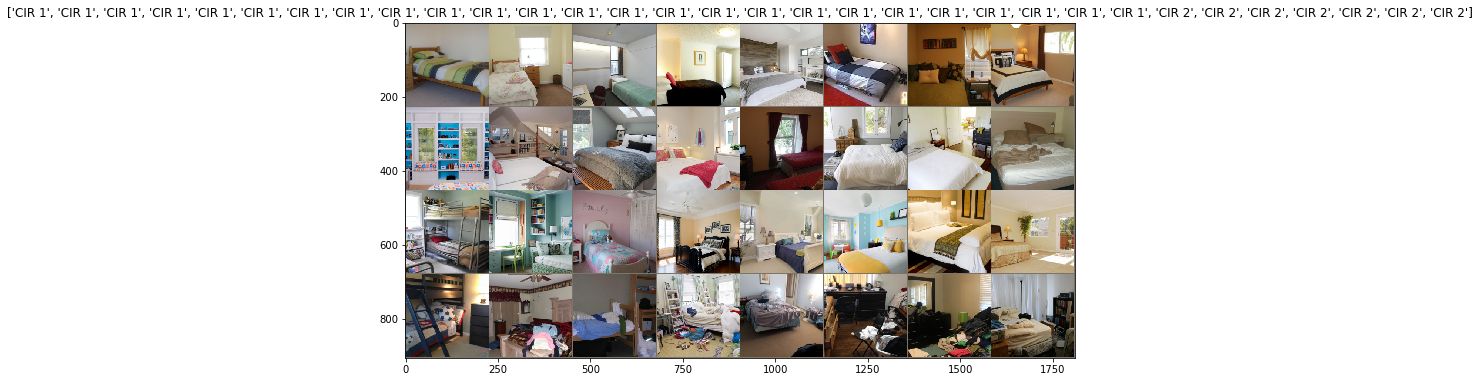

In [3]:
inputs, classes = next(iter(dset_loaders['val']))
out = torchvision.utils.make_grid(inputs,nrow=8)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

## 2- Log Keeping

This section includes the functions defined for the log keeping. Since CNNs require lots of trials, I found it easy to record the properties of the each trial with their performances in an excel file. I also added tnesorboard summaries for every trial and individual text files for showing the details of the network.

Below code declares the required parameters for the network which will be also used inside log keeping

In [3]:
network='resnet18' #Initial network archtiecture.'loaded'forusing a saved network
networkName='resnet18_real_sgd_multisoft_August29  19:06:27' #Directory for the saved network
optimizer='sgd' #Optimizer function
iter_loc=14 #Number of the first column in the excel file for writing the results.
end_to_end=True #Booolean to decide whether to train the network end-to-end or not.
lr=0.01 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
pretrained=True 
mse_loss=False #Scalar MSE loss
nclasses=9 #Number of output classes

'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

Let us define the functions for creating a text file and adding networkproperties to an excel file. 

In [4]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Random seed: '+str(random_seed)+'\n')
    f.write('Shuffle: '+str(shuffle)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Network: '+network+'\n')
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.write('Network is pretrained: '+str(pretrained)+'\n')
    f.write('Network laoded from: '+networkName+'\n')
    f.write('MSE loss function: '+str(mse_loss)+'\n')
    f.close()

In [5]:
import openpyxl
import time

def writeLog_xlsx(logname='logs.xlsx',iter_loc=14):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if network=='loaded':
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),networkName,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    else:
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),network,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

## 3 - Training and Validation

In this part we will define the functions for training a CNN with different properties and loss functions.

The following function takes bunch of properties defined in the beginning of Section-2 as input and creates network using those properties.

In [6]:
model_ft = models.resnet34(pretrained=pretrained)
num_ftrs = model_ft.fc.in_features
print(nclasses)
model_ft.fc = nn.Linear(num_ftrs, nclasses)

9


In [7]:
def network_loader(comment=comment,
                    network=network,
                    networkName=networkName,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    end_to_end=end_to_end,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    pretrained=pretrained,
                    mse_loss=mse_loss,
                    nclasses=nclasses):
    
    '''Load the network from pytorch'''
    if(network=='resnet18'):
        model_ft = models.resnet18(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features #Change the last layer to adapt new classes
        if(mse_loss): #For MSE loss last layer should be a scalar
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet34'):
        model_ft = models.resnet34(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet50'):
        model_ft = models.resnet50(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet101'):
        model_ft = models.resnet101(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='alexnet'):
        model_ft = models.alexnet(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].out_features
        setattr(model_ft.classifier, '7', nn.ReLU(inplace=True))
        setattr(model_ft.classifier, '8', nn.Dropout())
        setattr(model_ft.classifier, '9', nn.Linear(num_ftrs,nclasses))

    elif(network=='loaded'):#Use the saved network when network='loaded'
        model_ft = torch.load('./saved_models/'+networkName)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, nclasses)
    else:
        raise ValueError('Undefined network '+network)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

Now define a simple function to be able to run our training in a single line

In [8]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, nclasses))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, nclasses))

    prev_epoch = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            wb_tr.save('./runs/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
            wb_val.save('./runs/'+logname + '/val.xlsx')

            del label_arr_tr, label_arr_val, probs_arr_tr, probs_arr_val
            label_arr_tr = np.zeros((1,1))
            probs_arr_tr = np.zeros((1, nclasses))
            label_arr_val = np.zeros((1,1))
            probs_arr_val = np.zeros((1, nclasses))
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(nclasses))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(nclasses)), decimals=2)
        if result[0] == 'train':
            label_arr_tr  =np.append(label_arr_tr, label)
            probs_arr_tr = np.append(probs_arr_tr, probs, axis=0)
        elif result[0] == 'val':
            label_arr_val  =np.append(label_arr_val, label)
            probs_arr_val = np.append(probs_arr_val, probs, axis=0)



    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    wb_tr.save('./runs/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, nclasses))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, nclasses))
    prev_epoch = epoch
    print('Finito')

In [11]:
importlib.reload(ft)

def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            network=network,
                                            networkName=networkName,
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            end_to_end=end_to_end,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            pretrained=pretrained,
                                            mse_loss=mse_loss,
                                            nclasses=nclasses)
    
    '''Name of the trial'''
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname=network+'_'+'_'+optimizer+'_'+crt+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=30,batch_size=batch_size,num_log=250,
                            multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=mse_loss,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=nclasses)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/'+logname+'_best')
    torch.save(last_model,'./saved_models/'+logname+'_last')
    
    print('Writing results')
    write_epochs(result_log, logname)
    print('Wrote results')
    '''Free up the memory'''
    del model_ft, result_log
    


## 4 - Trials

The loss function we used in the experiments is the following,

$$loss(\mathbf{y},\hat{y})=(1-\lambda )loss_{single}(\mathbf{y},\hat{y})+\lambda loss_{multi}(\mathbf{y},\hat{y})$$
where $\mathbf{y}$ is the ground truth and $\hat{y}$ is the prediction.

Now lets test our function for different values of $\lambda$.

In [21]:
single_loss=1.
multi_loss=0.

for k in range(len(dset_loaders_arr)):
    dset_loaders = dset_loaders_arr[k]
    run_network()

Epoch 0/29
----------
LR is set to 0.01
train Loss: 0.0623 Acc: 0.2446 CIR-1: 0.5703 RMSE 2.3457
val Loss: 0.0906 Acc: 0.2532 CIR-1: 0.6818 RMSE 1.8950

Epoch 1/29
----------
train Loss: 0.0512 Acc: 0.4329 CIR-1: 0.7240 RMSE 1.6032
val Loss: 0.0700 Acc: 0.3506 CIR-1: 0.6721 RMSE 2.1006

Epoch 2/29
----------
train Loss: 0.0496 Acc: 0.4589 CIR-1: 0.7359 RMSE 1.6264
val Loss: 0.0810 Acc: 0.2922 CIR-1: 0.6234 RMSE 2.0552

Epoch 3/29
----------
train Loss: 0.0436 Acc: 0.5065 CIR-1: 0.7727 RMSE 1.4609
val Loss: 0.0699 Acc: 0.3214 CIR-1: 0.7338 RMSE 1.8340

Epoch 4/29
----------
train Loss: 0.0416 Acc: 0.5530 CIR-1: 0.7792 RMSE 1.4088
val Loss: 0.0861 Acc: 0.3247 CIR-1: 0.6981 RMSE 1.9565

Epoch 5/29
----------
train Loss: 0.0359 Acc: 0.6255 CIR-1: 0.8074 RMSE 1.3367
val Loss: 0.0899 Acc: 0.3442 CIR-1: 0.7175 RMSE 1.7572

Epoch 6/29
----------
train Loss: 0.0289 Acc: 0.6699 CIR-1: 0.8398 RMSE 1.2314
val Loss: 0.0774 Acc: 0.3312 CIR-1: 0.7045 RMSE 1.6778

Epoch 7/29
----------
train Loss: 0.0

In [22]:
single_loss=0.
multi_loss=1.

for k in range(len(dset_loaders_arr)):
    dset_loaders = dset_loaders_arr[k]
    run_network()
    
single_loss=.1
multi_loss=.9

for k in range(len(dset_loaders_arr)):
    dset_loaders = dset_loaders_arr[k]
    run_network()

Epoch 0/29
----------
LR is set to 0.01
train Loss: 0.0178 Acc: 0.2002 CIR-1: 0.5476 RMSE 2.3659
val Loss: 0.0148 Acc: 0.2857 CIR-1: 0.7532 RMSE 1.5811

Epoch 1/29
----------
train Loss: 0.0139 Acc: 0.2684 CIR-1: 0.7305 RMSE 1.6941
val Loss: 0.0133 Acc: 0.2922 CIR-1: 0.7597 RMSE 1.6768

Epoch 2/29
----------
train Loss: 0.0119 Acc: 0.3203 CIR-1: 0.8084 RMSE 1.3880
val Loss: 0.0126 Acc: 0.3052 CIR-1: 0.7922 RMSE 1.4550

Epoch 3/29
----------
train Loss: 0.0103 Acc: 0.3485 CIR-1: 0.8799 RMSE 1.1396
val Loss: 0.0119 Acc: 0.3182 CIR-1: 0.7987 RMSE 1.3266

Epoch 4/29
----------
train Loss: 0.0096 Acc: 0.3734 CIR-1: 0.8831 RMSE 1.1779
val Loss: 0.0119 Acc: 0.3442 CIR-1: 0.8117 RMSE 1.4085

Epoch 5/29
----------
train Loss: 0.0085 Acc: 0.4210 CIR-1: 0.9286 RMSE 1.0000
val Loss: 0.0118 Acc: 0.3214 CIR-1: 0.8312 RMSE 1.2868

Epoch 6/29
----------
train Loss: 0.0080 Acc: 0.3939 CIR-1: 0.9275 RMSE 1.0388
val Loss: 0.0120 Acc: 0.3669 CIR-1: 0.8084 RMSE 1.3031

Epoch 7/29
----------
train Loss: 0.0

In [16]:
single_loss=1.
multi_loss=0.
run_network()

NameError: name 'dset_loaders' is not defined

In [23]:
print(result_log)

[('train', 
 1
 4
 1
 5
 1
 0
 6
 3
 0
 5
 8
 4
 0
 1
 5
 1
 5
 5
 6
 7
 6
 5
 6
 4
 7
 5
 4
 1
 0
 4
 0
 6
[torch.cuda.LongTensor of size 32 (GPU 0)]
, 
 0.8239 -1.2255  1.1602  0.6775 -0.4415  0.2001  0.5041  1.3018  0.0571
 0.3691 -0.9169  0.3091  0.3861 -0.3927 -0.2602  0.7428  0.7701 -1.0936
 0.8225 -1.0897 -0.1250  0.8289 -0.0816  0.2734  0.1475  0.7673 -0.4283
 0.5643 -0.3269  0.4399  0.1855  0.1251 -0.2871  1.2762  0.0056 -0.4228
 0.6547 -1.3539  0.7592  1.1515 -0.9063 -0.0715  0.1399  0.6090 -0.9836
 0.4771 -1.2539 -0.3445  0.5910 -1.3161  0.2699  1.0263  0.9813 -1.0826
 0.0874 -1.2875  0.6911  0.3516 -0.3201 -0.3436  0.5896  0.8623 -0.2851
 1.1811 -0.1694  0.5654 -0.1006  0.1412  0.7100 -0.2511  0.8325 -0.1905
 0.6546 -1.1104  0.3039  0.4666 -0.5024  0.4380  0.6311  0.9706 -0.6613
 0.9229 -0.7054  0.9716 -0.1449 -0.2624 -0.3143  0.7083  0.8653  0.7611
 1.0929 -0.4508 -0.0213 -0.4744  0.4262 -0.1328  1.2024  0.2097 -1.0126
 0.0758 -1.0605  0.4391  0.3238 -0.6660  0.5624  0.615

In [16]:
mse_loss=False
for lmbda in [1., 1., 1., 1., 1.]:
    single_loss= round(1.-lmbda, 1)
    multi_loss = lmbda
    print('Single loss = '+str(single_loss)+', Multi loss = '+str(multi_loss))
    run_network()

Single loss = 0.0, Multi loss = 1.0
Epoch 0/49
----------
LR is set to 0.01
train Loss: 0.0180 Acc: 0.2282 CIR-1: 0.5833 RMSE 2.2658
val Loss: 0.0168 Acc: 0.2444 CIR-1: 0.6667 RMSE 1.7676

Epoch 1/49
----------
train Loss: 0.0134 Acc: 0.2937 CIR-1: 0.7659 RMSE 1.5862
val Loss: 0.0160 Acc: 0.2533 CIR-1: 0.6711 RMSE 1.6330

Epoch 2/49
----------
train Loss: 0.0116 Acc: 0.3234 CIR-1: 0.8204 RMSE 1.3533
val Loss: 0.0159 Acc: 0.2667 CIR-1: 0.7244 RMSE 1.4560

Epoch 3/49
----------
train Loss: 0.0103 Acc: 0.3690 CIR-1: 0.8810 RMSE 1.2027
val Loss: 0.0148 Acc: 0.2400 CIR-1: 0.7289 RMSE 1.5592

Epoch 4/49
----------
train Loss: 0.0092 Acc: 0.3750 CIR-1: 0.9018 RMSE 1.0852
val Loss: 0.0145 Acc: 0.2667 CIR-1: 0.7867 RMSE 1.4591

Epoch 5/49
----------
train Loss: 0.0081 Acc: 0.4147 CIR-1: 0.9375 RMSE 1.0104
val Loss: 0.0147 Acc: 0.2444 CIR-1: 0.7600 RMSE 1.5776

Epoch 6/49
----------
train Loss: 0.0075 Acc: 0.4554 CIR-1: 0.9544 RMSE 0.9533
val Loss: 0.0156 Acc: 0.2622 CIR-1: 0.7289 RMSE 1.6613

E